# prep

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [3]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_LM = meta.copy()
meta_LM.tail()

LM    22
Name: area, dtype: int64 22


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
17,1373,230302,LM,200.0,3,1.0,NaN,grating,6s,NaN,NaN
18,1373,230302,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN
19,1381,230307,LM,200.0,2,1.0,NaN,grating,6s,NaN,NaN
20,1381,230307,LM,200.0,3,1.0,NaN,grating,6s,NaN,NaN
21,1381,230307,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN


In [4]:
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_V1 = meta.copy()
meta_V1

V1    6
Name: area, dtype: int64 6


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1323,200720,V1,200.0,3,NaN,True,grating,6s,1.0,NaN
1,1324,200728,V1,200.0,3,NaN,True,grating,6s,NaN,NaN
2,1322,200803,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
3,1328,201015,V1,200.0,4,NaN,True,grating,6s,1.0,NaN
4,1329,201209,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
5,1337,210120,V1,150.0,3,1.0,NaN,grating,6s,NaN,NaN


# df tidy for 1 set
grat 8ori 3isi

In [95]:
iset = 20

mouse = meta.loc[iset, 'mouse'].astype(str)
date = meta.loc[iset, 'date'].astype(str)
area = meta.loc[iset, 'area']
sess = '00' + meta.loc[iset, 'num'].astype(str)
print(mouse, date, area, sess)

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
for dirname in os.listdir(dir_data):
    if mouse in dirname and date in dirname and area in dirname and sess in dirname:
        dir_data = dir_data + dirname
        break

stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

1381 230307 LM 002
ncell: 87, nstim: 1, ntrial: 500, nframe: 207


(dict_keys(['stim_ori', 'isi_nframe', 'adapter_contrast']), (87, 500, 207))

trace_cell_avg: (207,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (207,)


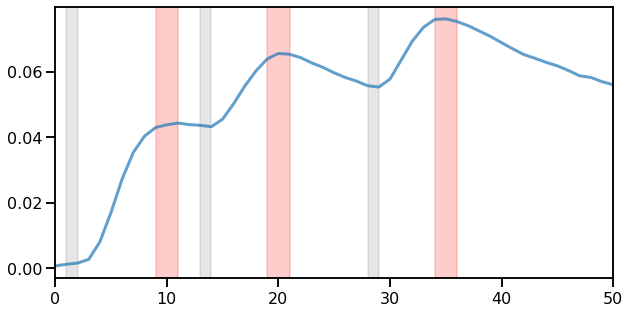

In [ ]:
## find resp window. TODO: auto detect
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

base1_frame = 1
resp_ad_frame = 9
base2_frame = 13
resp_tg250_frame = 19
base3_frame = 28
resp_tg750_frame = 34

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell, alpha=0.7, linewidth=3)
ax.axvspan(base1_frame, base1_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_ad_frame, resp_ad_frame+2, alpha=0.2, color='red')
ax.axvspan(base2_frame, base2_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg250_frame, resp_tg250_frame+2, alpha=0.2, color='red')
ax.axvspan(base3_frame, base3_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg750_frame, resp_tg750_frame+2, alpha=0.2, color='red')
plt.xlim(0, 50);

In [ ]:
## get resp_ad and resp_tg [cell x trial]

base1 = trace_by_trial[:, :, base1_frame : base1_frame+1+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:, :, resp_ad_frame : resp_ad_frame+2+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:, :, base2_frame : base2_frame+1+1].mean(axis=2)
resp_tg250 = trace_by_trial[:, :, resp_tg250_frame : resp_tg250_frame+2+1].mean(axis=2)
resp_tg250 = resp_tg250 - base2

base3 = trace_by_trial[:, :, base3_frame : base3_frame+1+1].mean(axis=2)
resp_tg750 = trace_by_trial[:, :, resp_tg750_frame : resp_tg750_frame+2+1].mean(axis=2)
resp_tg750 = resp_tg750 - base3

resp_ad.shape, resp_tg250.shape, resp_tg750.shape

((87, 500), (87, 500), (87, 500))

In [ ]:
trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]

## stitch resp_tg250 and resp_tg750 together, based on trial_isi_nframe
ntrial = resp_ad.shape[1]
resp_tg = np.zeros_like(resp_ad)
for itrial in range(ntrial):
    resp_tg[:, itrial] = resp_tg250[:, itrial] if trial_isi_nframe[itrial] < 10 else resp_tg750[:, itrial]
# print(np.unique(trial_isi_nframe)) # 10 > 8 frame == 250 ms

R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
R2_dfof = resp_tg.flatten()
dfof = np.hstack((R1_dfof, R2_dfof))

In [ ]:
ncell = resp_ad.shape[0]
ntrial = resp_ad.shape[1]
cell_id = np.repeat(np.arange(ncell), ntrial)
cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

trial_id = np.tile(np.arange(ntrial), ncell)
trial_id = np.hstack((trial_id, trial_id))

len_df = ncell * ntrial * 2 # 2 for (R1, R2)
resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

cell_id.shape, trial_id.shape, dfof.shape, len(resp_id)

((87000,), (87000,), (87000,), 87000)

In [ ]:
## map stim2 orientation to int
trial_stim_orien = [item[0] for item in stim_id['stim_ori']]
print(np.sort(np.unique(trial_stim_orien)))

trial_stim_orien_dict = {}
for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
    trial_stim_orien_dict[item] = i
trial_stim_orien_dict

trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]


In [ ]:
trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
trial_isi_nframe = trial_isi_nframe[:ntrial]
trial_adapter_contrast = trial_adapter_contrast[:ntrial]

stim_id_col = np.tile(trial_stim_orien_int, ncell)
isi_col = np.tile(trial_isi_nframe, ncell)
ad_con_col = np.tile(trial_adapter_contrast, ncell)
stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
adapter_id_col = np.zeros_like(stim_id_col)
isi_col = np.hstack((isi_col, isi_col))
ad_con_col = np.hstack((ad_con_col, ad_con_col))

stim_id_col.shape, isi_col.shape, ad_con_col.shape, adapter_id_col.shape

((87000,), (87000,), (87000,), (87000,))

In [ ]:
df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                        'isi': isi_col, 'stim1_contrast': ad_con_col, 
                        'stim2_id': stim_id_col, 'stim1_id': adapter_id_col,})
df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id
0,0.399759,0,0,R1,8,1,3,0
1,0.027992,0,3,R1,23,1,6,0
2,0.054808,0,6,R1,8,1,3,0
3,0.029828,0,8,R1,23,1,5,0
4,-0.012044,0,11,R1,23,1,2,0
...,...,...,...,...,...,...,...,...
74293,0.011308,86,495,R2,23,1,2,0
74294,-0.008860,86,496,R2,23,1,7,0
74295,-0.039800,86,497,R2,8,1,2,0
74296,-0.011214,86,498,R2,8,1,5,0


In [ ]:
## vis cell filter & img driven cell-stim filter

df_tidy['filter_cell'] = np.nan
df_tidy['filter_cell_stim'] = np.nan

with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
    filter_file = pickle.load(f)
filter_cell_stim = filter_file['img_driven']
filter_cell = filter_file['vis_driven']

print(f'ncell = {filter_cell_stim.shape[0]}, nstim = {filter_cell_stim.shape[1]}')
for icell in np.arange(filter_cell_stim.shape[0]):
    df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
    for istim in np.arange(filter_cell_stim.shape[1]):
        df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
        
df_tidy
# df_tidy.filter_cell.value_counts(), df_tidy.filter_cell_stim.value_counts()

ncell = 87, nstim = 8


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,filter_cell,filter_cell_stim
0,0.399759,0,0,R1,8,1,3,0,False,False
1,0.027992,0,3,R1,23,1,6,0,False,False
2,0.054808,0,6,R1,8,1,3,0,False,False
3,0.029828,0,8,R1,23,1,5,0,False,False
4,-0.012044,0,11,R1,23,1,2,0,False,False
...,...,...,...,...,...,...,...,...,...,...
74293,0.011308,86,495,R2,23,1,2,0,True,False
74294,-0.008860,86,496,R2,23,1,7,0,True,False
74295,-0.039800,86,497,R2,8,1,2,0,True,False
74296,-0.011214,86,498,R2,8,1,5,0,True,False


# df tidy for n set

## find resp window

In [9]:
trace_avg_cell_set = []
# meta = meta_V1.copy()
meta = meta_LM.copy()
nset = meta.shape[0]

for iset in range(nset):

    mouse = meta.loc[iset, 'mouse'].astype(str)
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(mouse, date, area, sess)

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(dir_data):
        if mouse in dirname and date in dirname and area in dirname and sess in dirname:
            dir_data = os.path.join(dir_data, dirname)
            break

    stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
    stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

    trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)
    trace_avg_cell_set.append(trace_avg_cell)

trace_avg_cell_set = np.array(trace_avg_cell_set)
clear_output()

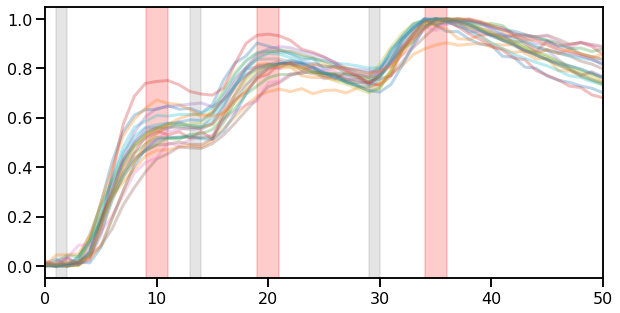

In [12]:
base1_frame = 1
resp_ad_frame = 9
base2_frame = 13
resp_tg250_frame = 19
base3_frame = 29
resp_tg750_frame = 34

fig, ax = plt.subplots(figsize=(10, 5))
for iset in range(nset):
    trace_now = trace_avg_cell_set[iset]
    # max min normalization
    trace_now = (trace_now - np.min(trace_now) ) / (np.max(trace_now) - np.min(trace_now))
    plt.plot(trace_now, alpha=0.3, linewidth=3)

ax.axvspan(base1_frame, base1_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_ad_frame, resp_ad_frame+2, alpha=0.2, color='red')
ax.axvspan(base2_frame, base2_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg250_frame, resp_tg250_frame+2, alpha=0.2, color='red')
ax.axvspan(base3_frame, base3_frame+1, alpha=0.2, color='gray')
ax.axvspan(resp_tg750_frame, resp_tg750_frame+2, alpha=0.2, color='red')

plt.xlim(0, 50);

## batch write df_tidy

In [8]:
for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')

    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(mouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
    # stim_id.keys(), trace_by_trial.shape # NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial

    ## slice by resp window, determined by section above
    ## get resp_ad and resp_tg [cell x trial]
    base1 = trace_by_trial[:, :, base1_frame : base1_frame+1+1].mean(axis=2) # avg over time window frames. one more plus 1 is to include the last frame
    resp_ad = trace_by_trial[:, :, resp_ad_frame : resp_ad_frame+2+1].mean(axis=2)
    resp_ad = resp_ad - base1

    base2 = trace_by_trial[:, :, base2_frame : base2_frame+1+1].mean(axis=2)
    resp_tg250 = trace_by_trial[:, :, resp_tg250_frame : resp_tg250_frame+2+1].mean(axis=2)
    resp_tg250 = resp_tg250 - base2

    base3 = trace_by_trial[:, :, base3_frame : base3_frame+1+1].mean(axis=2)
    resp_tg750 = trace_by_trial[:, :, resp_tg750_frame : resp_tg750_frame+2+1].mean(axis=2)
    resp_tg750 = resp_tg750 - base3

    ## construct dfof
    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    ntrial = resp_ad.shape[1]
    resp_tg = np.zeros_like(resp_ad)
    for itrial in range(ntrial): # stitch resp_tg250 and resp_tg750 together, based on trial_isi_nframe
        resp_tg[:, itrial] = resp_tg250[:, itrial] if trial_isi_nframe[itrial] < 10 else resp_tg750[:, itrial]
    # print(np.unique(trial_isi_nframe)) # NOTE 10 > 8 frame == 250 ms

    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof))

    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial)
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

    trial_id = np.tile(np.arange(ntrial), ncell)
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

    ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
    trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
    trial_stim_orien_dict = {} ## map stim2 orientation to int
    for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
        trial_stim_orien_dict[item] = i
    trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

    trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
    trial_isi_nframe = trial_isi_nframe[:ntrial]
    trial_adapter_contrast = trial_adapter_contrast[:ntrial]

    stim_id_col = np.tile(trial_stim_orien_int, ncell)
    isi_col = np.tile(trial_isi_nframe, ncell)
    ad_con_col = np.tile(trial_adapter_contrast, ncell)

    stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
    adapter_id_col = np.zeros_like(stim_id_col) # adapter (stim1) is always 0 deg / vertical gratings
    isi_col = np.hstack((isi_col, isi_col))
    ad_con_col = np.hstack((ad_con_col, ad_con_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                            'isi': isi_col, 'stim1_contrast': ad_con_col, 
                            'stim2_id': stim_id_col, 'stim1_id': adapter_id_col,})
    df_tidy['area'] = area
    df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
    df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    df_tidy['filter_cell_well_fit'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
    well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']]) # bool, ncell x 1

    # print(f'ncell = {filter_cell_stim.shape[0]}, nstim = {filter_cell_stim.shape[1]}')
    for icell in np.arange(filter_cell_stim.shape[0]):
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell][0] # filter_cell_vis is a list of list
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()

    ## cell tuning in 3 possible ISI
    fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat'))
    ori_pref_isi3 = fit_tuning['ori_pref'] # ncell x 3isi, [noad vs ad750 vs ad250]
    
    df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms
    df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)

    ncell = df_tidy.cell_id.unique().shape[0]
    for icell in np.arange(ncell):
        df_tidy.loc[(df_tidy.cell_id == icell) & (df_tidy.isi == 6000), 'ori_pref'] = ori_pref_isi3[icell, 0] # ori_pref_isi3 is ncell x 3isi, [noad vs ad750 vs ad250]
        df_tidy.loc[(df_tidy.cell_id == icell) & (df_tidy.isi == 750), 'ori_pref'] = ori_pref_isi3[icell, 1]
        df_tidy.loc[(df_tidy.cell_id == icell) & (df_tidy.isi == 250), 'ori_pref'] = ori_pref_isi3[icell, 2]
    
    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy.csv'), index=False)

clear_output()

# batch load df_tidy

In [13]:
meta = pd.concat([meta_V1, meta_LM], axis=0).reset_index(drop=True)
meta.sample(5)

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
6,1323,200721,LM,200.0,2,NaN,True,grating,6s,1.0,NaN
3,1328,201015,V1,200.0,4,NaN,True,grating,6s,1.0,NaN
2,1322,200803,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
12,1329,201217,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN
14,1337,210127,LM,150.0,3,1.0,NaN,grating,6s,NaN,NaN


In [14]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, 'df_tidy.csv'))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, 'df_tidy.csv'))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [15]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.sess.unique(), 
      df_tidy.area.unique(), 
      df_tidy.isi.unique(), 
      df_tidy.stim1_contrast.unique(), 
      df_tidy.stim2_id.unique(), 
      df_tidy.resp_id.unique())
df_tidy.sample(5)

['1323' '1324' '1322' '1328' '1329' '1337' '1338' '1350' '1351' '1380'
 '1373' '1381'] ['200720' '200728' '200803' '201015' '201209' '210120' '200721' '200729'
 '200804' '201119' '201127' '201217' '210127' '210325' '210805' '211020'
 '220228' '230221' '230302' '230307'] ['003' '002' '004'] ['V1' 'LM'] [ 750  250 6000] [1 0] [5 2 3 0 7 4 1 6] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_stim,ori_pref,mouse,date,sess
1368100,0.028029,230221_003_30,456,R2,250,1,3,0,LM,True,0.0,False,125.382669,1380,230221,003
1169811,0.057707,211020_003_53,224,R2,750,1,7,0,LM,True,0.0,True,132.796664,1350,211020,003
948988,0.010047,210325_002_15,14,R1,750,1,1,0,LM,True,0.0,True,143.189346,1338,210325,002
1702740,0.118025,230307_003_53,21,R1,250,1,0,0,LM,True,1.0,False,91.287112,1381,230307,003
23539,0.003275,200720_003_73,152,R1,250,1,1,0,V1,False,0.0,False,29.856334,1323,200720,003


# re_well_fit for cell filter
## well_fit try first

In [19]:
# TODO: rerun well_fit using bootstrap von-mises fit, then try redefine well_fit as re_well_fit
# test w Z:\All_Staff\home\lan\Data\2P_images\mat_inter\LM_i1323_200721_002

df_now = df_tidy[(df_tidy.mouse == '1323') & (df_tidy.date == '200721') & (df_tidy.sess == '002') & (df_tidy.area == 'LM')].reset_index(drop=True)
df_now

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_identifier = 'LM_i1323_200721_002'
well_fit = sio.loadmat(os.path.join(dir_data, dir_identifier, 'fit_bootstrap_90perc.mat'))
# well_fit['well_fit_cell'].shape, well_fit['fit_param_runs'].shape, well_fit['ori_pref_runs'].shape, well_fit['ori_perc'].shape, 

In [27]:
fit_tuning = sio.loadmat(os.path.join(dir_data, dir_identifier, 'fit_tuning_isi3.mat'))
type(fit_tuning['ori_pref'])

numpy.ndarray

In [14]:
well_fit_cell = [x[0] for x in well_fit['well_fit_cell']]
well_fit_cell

[0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0]

# tuning bias
x: (pref_ori_unadapted - adapter_ori).abs.binned  
y: distance(pref_ori_unadapted, 0 deg) - distance(pref_ori_adapted, 0 deg)

## pref_ori for cell, no adapter or with adapter
crude preference: take max-resp orientation as the preferred orien

In [42]:
for icell in tqdm(df_tidy.cell_id.unique()):

    ## max resp ori as pref
    df_icell_noad = df_tidy[(df_tidy.cell_id == icell) & (df_tidy.stim1_contrast == 0)] # no adapter trials for this cell
    # df_icell_noad.groupby(['stim2_id']).sum()['dfof'].plot() # check tuning curve
    df_icell_ad_250 = df_tidy[(df_tidy.cell_id == icell) & (df_tidy.stim1_contrast == 1)
                              & (df_tidy.isi == 250)] # with adapter trials for this cell, isi = 250
    df_icell_ad_750 = df_tidy[(df_tidy.cell_id == icell) & (df_tidy.stim1_contrast == 1)
                              & (df_tidy.isi == 750)] # with adapter trials for this cell, isi = 750
    
    df_tidy.loc[(df_tidy.cell_id == icell), 'max_ori_noad'] = df_icell_noad.groupby(['stim2_id'], sort=True).sum()['dfof'].argmax() * 22.5 # sort to make sure stim2_id is in order, so argmax() returns the correct stim2_id, convert to deg
    df_tidy.loc[(df_tidy.cell_id == icell), 'max_ori_ad_250'] = df_icell_ad_250.groupby(['stim2_id'], sort=True).sum()['dfof'].argmax() * 22.5
    df_tidy.loc[(df_tidy.cell_id == icell), 'max_ori_ad_750'] = df_icell_ad_750.groupby(['stim2_id'], sort=True).sum()['dfof'].argmax() * 22.5

    ## pref ori as pref
    df_tidy.loc[(df_tidy.cell_id == icell), 'pref_ori_noad'] = df_icell_noad['ori_pref'].values[0] # only one value for each cell x isi
    df_tidy.loc[(df_tidy.cell_id == icell), 'pref_ori_ad_250'] = df_icell_ad_250['ori_pref'].values[0]
    df_tidy.loc[(df_tidy.cell_id == icell), 'pref_ori_ad_750'] = df_icell_ad_750['ori_pref'].values[0]
    # break

df_tidy[(df_tidy.cell_id == icell)]

100%|██████████| 2298/2298 [31:24<00:00,  1.22it/s]


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,area,filter_cell_vis,...,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,max_ori_noad,max_ori_ad_250,max_ori_ad_750
1802312,-0.041101,230307_004_99,0,R1,250,1,0,0,LM,False,...,105.234348,157.576048,157.875266,67.5,90,90.0,22.5,112.5,90.0,67.5
1802313,-0.027357,230307_004_99,1,R1,250,1,0,0,LM,False,...,105.234348,157.576048,157.875266,67.5,90,90.0,22.5,112.5,90.0,67.5
1802314,0.016074,230307_004_99,2,R1,250,1,7,0,LM,False,...,105.234348,157.576048,157.875266,67.5,90,90.0,22.5,112.5,90.0,67.5
1802315,-0.025278,230307_004_99,3,R1,250,1,0,0,LM,False,...,105.234348,157.576048,157.875266,67.5,90,90.0,22.5,112.5,90.0,67.5
1802316,0.031836,230307_004_99,4,R1,250,1,5,0,LM,False,...,105.234348,157.576048,157.875266,67.5,90,90.0,22.5,112.5,90.0,67.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852658,-0.007216,230307_004_99,495,R2,750,1,1,0,LM,False,...,105.234348,157.576048,157.875266,67.5,90,67.5,0.0,112.5,90.0,67.5
1852659,0.051553,230307_004_99,496,R2,750,1,2,0,LM,False,...,105.234348,157.576048,157.875266,67.5,90,67.5,0.0,112.5,90.0,67.5
1852660,-0.030096,230307_004_99,497,R2,250,1,7,0,LM,False,...,105.234348,157.576048,157.875266,67.5,90,90.0,22.5,112.5,90.0,67.5
1852661,0.001124,230307_004_99,498,R2,250,1,2,0,LM,False,...,105.234348,157.576048,157.875266,67.5,90,90.0,22.5,112.5,90.0,67.5


In [61]:
# def find_nearest_neighbor(array, value):
#     idx = (np.abs(array - value)).argmin()
#     return array[idx]

# test_arr = [1, 15, 22, 44, 89]
# test_value = np.arange(0, 90+22.5, 22.5)
# find_nearest_neighbor(test_arr, test_value)

1

In [62]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    # if x < 30:
    #     return 0
    # elif x <= 60:
    #     return 45
    # else:
    #     return 90
    if x < 22.5 / 2:
        return 0
    elif x < 22.5 / 2 * 3:
        return 22.5
    elif x < 22.5 / 2 * 5:
        return 22.5 * 2
    elif x < 22.5 / 2 * 7:
        return 22.5 * 3
    else:
        return 22.5 * 4

def distace_from_adapter(x):
    # adapter is always 0 deg
    # x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['pref_ori_noad'].apply(lambda x: distace_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: 22.5 * bin_array(x, np.arange(0, 90+22.5, 22.5))) # bin the distance to 0, 45, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_250'].apply(lambda x: distace_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_750'].apply(lambda x: distace_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter

df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias.csv'), index=False)

df_tidy.sample(5)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,area,filter_cell_vis,...,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,max_ori_noad,max_ori_ad_250,max_ori_ad_750
747382,-0.029441,201217_002_86,183,R2,250,1,3,0,LM,True,...,0.781039,8.944618,174.324473,0.781039,0.0,8.944618e+00,8.163579,0.0,22.5,157.5
417558,0.038466,210120_003_23,25,R1,750,1,7,0,V1,True,...,39.341545,71.681472,6.550275,39.341545,45.0,6.550275e+00,-32.791270,22.5,67.5,90.0
638736,0.200915,201119_003_65,333,R2,750,1,1,0,LM,False,...,157.352304,177.443551,81.183608,22.647696,22.5,8.118361e+01,58.535912,135.0,22.5,0.0
1556502,0.135536,230302_004_35,233,R2,250,1,5,0,LM,True,...,3.665824,180.000000,6.191062,3.665824,0.0,2.804086e-09,-3.665824,22.5,0.0,22.5
1156689,0.062501,211020_003_25,66,R2,750,1,3,0,LM,False,...,134.241114,104.562794,117.030727,45.758886,45.0,6.296927e+01,17.210387,112.5,112.5,45.0


## tuning bias plot

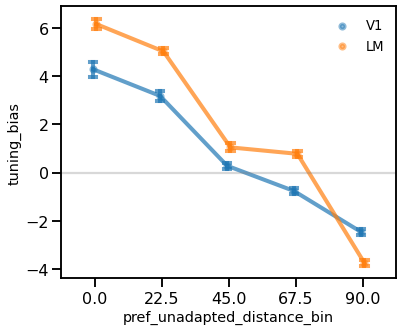

In [64]:
df_filter = df_tidy[(df_tidy.filter_cell_vis == True) 
                    # & (df_tidy.filter_cell_stim == True)
                    & (df_tidy.filter_cell_well_fit == True)
                    & (df_tidy.isi == 250)
                    ]

fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
ax = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   dodge=True, markers='.', 
                   errorbar=('ci', 95), errwidthfloat=1, capsize=.1,
                #    linestyles=["-", "--", "dashdot"], 
                   )
plt.setp(ax.collections, alpha=.5);
plt.setp(ax.lines, alpha=.7);
plt.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.legend(frameon=False);

In [26]:
tmp = df_tidy.sample(5, random_state=0)
tmp['pref_ori_noad'] = tmp['pref_ori_noad'] * 22.5
tmp['pref_ori_ad_250'] = tmp['pref_ori_ad_250'] * 22.5
tmp['pref_ori_ad_750'] = tmp['pref_ori_ad_750'] * 22.5
tmp#.filter_cell_well_fit

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,stim1_id,area,filter_cell_vis,...,mouse,date,sess,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
427815,0.046942,210120_003_54,193,R1,750,1,1,0,V1,True,...,1337,210120,003,157.5,157.5,0.0,22.5,0,0.0,-22.5
721733,0.453832,201217_002_31,54,R2,750,1,0,0,LM,False,...,1329,201217,002,45.0,157.5,157.5,45.0,45,22.5,-22.5
1571067,0.055667,230302_004_64,298,R2,250,1,6,0,LM,True,...,1373,230302,004,45.0,45.0,45.0,45.0,45,45.0,0.0
537328,-0.192195,200804_003_19,306,R1,250,1,4,0,LM,True,...,1322,200804,003,112.5,67.5,67.5,67.5,90,67.5,0.0
212258,-0.018074,200803_002_58,122,R2,6000,0,4,0,V1,True,...,1322,200803,002,157.5,157.5,135.0,22.5,0,NaN,NaN


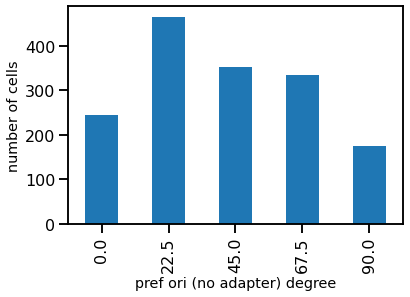

In [323]:
df_filter.groupby('pref_unadapted_distance').cell_id.nunique().sort_index().plot(kind='bar')
# plt.xticks(np.arange(0, 5, 1), np.arange(0, 90+22.5, 22.5), rotation=45)
plt.xlabel('pref ori (no adapter) degree')
plt.ylabel('number of cells');

## adaptation by area

(-0.06175239476718727, -0.034464397239895354)

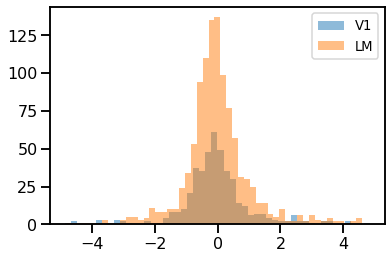

In [338]:
def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    gb_adp = gb_adp[np.abs(gb_adp) < 5]

    return gb_adp

gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])

plt.hist(gb_adp_V1, bins=50, alpha=.5, label='V1')
plt.hist(gb_adp_LM, bins=50, alpha=.5, label='LM')
plt.legend();
np.mean(gb_adp_V1), np.mean(gb_adp_LM)